In [66]:
# Это просто чтобы на проекторе всё было красиво.
# Не обращайте внимания

from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.8em;
line-height:1.0em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.4em;
line-height:1.3em;
padding-left:2em;
padding-right:2em;
}
</style>
""")

In [67]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
import pandas as pd


## Где логистическая регрессия хороша и где не очень

### Анализ отзывов IMDB к фильмам

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет  – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой

<img src="https://hsto.org/files/a0a/bb1/2e9/a0abb12e9ed94624ade0b9090d26ad66.png" width=80%>

In [68]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) (это прямая ссылка на скачивание, а [вот](http://ai.stanford.edu/~amaas/data/sentiment/) описание набора данных). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [69]:
import tarfile
file = tarfile.open('aclImdb_v1.tar.gz')
file.extractall()
file.close()

In [70]:
# распакуйте архив в папку data
reviews_train = load_files("aclImdb/train", categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

In [71]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [72]:
reviews_test = load_files("aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [73]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [74]:
y_train[1] # плохой отзыв

0

In [75]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [76]:
y_train[2] # хороший отзыв

1

## Простой подсчет слов

**Составьте словарь всех слов с помощью CountVectorizer.**

In [77]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [78]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02'
 '020410' '029' '03' '04' '041' '05' '050' '06' '06th' '07' '08' '087'
 '089' '08th' '09' '0f' '0ne' '0r' '0s' '10' '100' '1000' '1000000'
 '10000000000000' '1000lb' '1000s' '1001' '100b' '100k' '100m']
['pincher' 'pinchers' 'pinches' 'pinching' 'pinchot' 'pinciotti' 'pine'
 'pineal' 'pineapple' 'pineapples' 'pines' 'pinet' 'pinetrees' 'pineyro'
 'pinfall' 'pinfold' 'ping' 'pingo' 'pinhead' 'pinheads' 'pinho' 'pining'
 'pinjar' 'pink' 'pinkerton' 'pinkett' 'pinkie' 'pinkins' 'pinkish'
 'pinko' 'pinks' 'pinku' 'pinkus' 'pinky' 'pinnacle' 'pinnacles' 'pinned'
 'pinning' 'pinnings' 'pinnochio' 'pinnocioesque' 'pino' 'pinocchio'
 'pinochet' 'pinochets' 'pinoy' 'pinpoint' 'pinpoints' 'pins' 'pinsent']


**Закодируйте предложения из текстов обучающей выборки индексами входящих слов.**

In [79]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [80]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [81]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [82]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

**Преобразуйте так же тестовую выборку.**

In [83]:
X_test = cv.transform(text_test)

**Обучите логистическую регрессию.** <p> Используйте класс [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Не забудьте зафиксировать random_state.

In [84]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 97.6 ms, sys: 157 ms, total: 255 ms
Wall time: 5.65 s


LogisticRegression(n_jobs=-1, random_state=7)

**Выведите доли правильных ответов на обучающей и тестовой выборках.** <p> **Hint:** у класса логрегрессии есть метод на это.

In [85]:
print(f'доля правильных ответов на обучающей выборке {logit.score(X_train, y_train)}')

доля правильных ответов на обучающей выборке 0.98192


In [86]:
print(f'доля правильных ответов на тестовой выборке {logit.score(X_test, y_test)}')

доля правильных ответов на тестовой выборке 0.864


**Теперь то же самое, но со случайным лесом.**

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

In [88]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1min 44s, sys: 91.2 ms, total: 1min 45s
Wall time: 1min 51s


RandomForestClassifier()

In [89]:
clf.score(X_test, y_test)

0.8456

Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями

### XOR-проблема
Теперь рассмотрим пример, где линейные модели справляются хуже.

Линейные методы классификации строят все же очень простую разделяющую поверхность – гиперплоскость. Самый известный игрушечный пример, в котором классы нельзя без ошибок поделить гиперплоскостью (то есть прямой, если это 2D), получил имя "the XOR problem".

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

<img src='https://hsto.org/files/aa7/c61/7c9/aa7c617c9ce4458d88979b6d44a1e2fa.gif'>

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек.

In [90]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

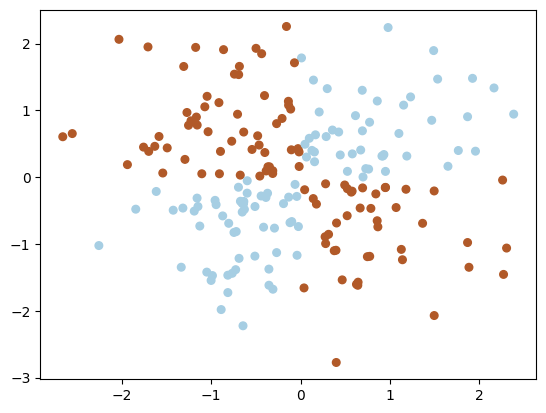

In [91]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Очевидно, нельзя провести прямую так, чтобы без ошибок отделить один класс от другого. Поэтому логистическая регрессия плохо справляется с такой задачей.

In [92]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

Теперь, используя функцию, объявленную выше, обучите логистическую регрессию.

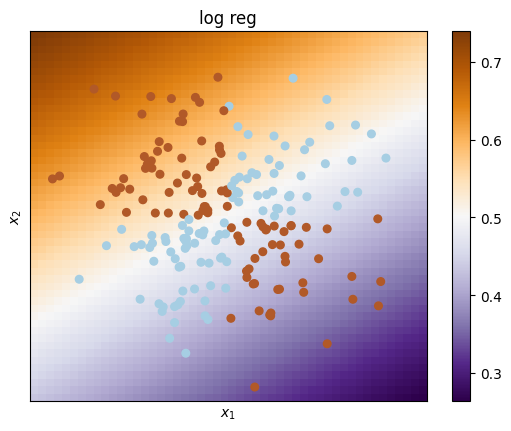

In [93]:
plot_boundary(LogisticRegression(), X, y, "log reg")

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается.

Теперь, сделайте точно так же, как в прошлой ячейке, но теперь используйте данные, предобработанные до полинома второй степени.

**Hint:** Используйте [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) и [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

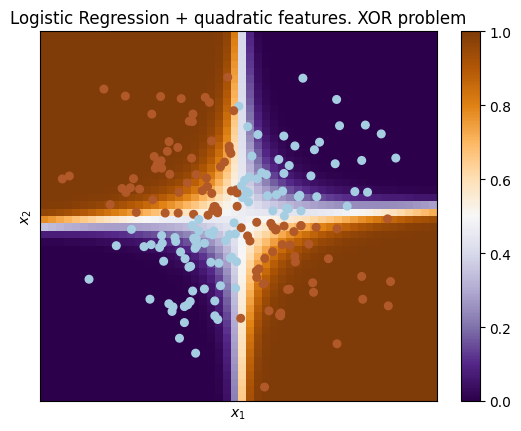

In [94]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
logitPipe = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])
plot_boundary(logitPipe, X, y, "Logistic Regression + quadratic features. XOR problem")

Здесь логистическая регрессия все равно строила гиперплоскость, но в 6-мерном пространстве признаков $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. В проекции на исходное пространство признаков $x_1, x_2$ граница получилась нелинейной.

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком. При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится. Про это подробно можно почитать в курсе Евгения Соколова – тут (математика уже серьезная).

## Метрики качества бинарной классификации

Из лекции вы узнали про алгоритмы, которые выдают вероятности принадлежности классу. Но в классификации требуется четко сказать имя класса объекта. Значит, нужно уметь выбирать пороги $T$ для перевода вероятностей в классы. Поэтому необходимы дополнительные подходы для оценки таких алгоритмов, так как классические accuracy, f1 и прочие не принимают во внимание вероятностную природу предсказания.

В этой практике мы посмотрим как можно визуализировать precision-recall кривую и ROC_AUC кривую.

### Литература

- практикика из курса от МФТИ на coursera
- [AUC ROC - alexanderdyakonov](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)

Рассмотрим несколько вариантов векторов предсказаний вероятностей принадлежности классам. Каждый из вариантов будет показывать особенности классификаторов.

In [95]:
# рисует один scatter plot
def scatter(actual, predicted, T):
    plt.scatter(actual, predicted)
    plt.xlabel("Labels")
    plt.ylabel("Predicted probabilities")
    plt.plot([-0.2, 1.2], [T, T])
    plt.axis([-0.1, 1.1, -0.1, 1.1])

# рисует несколько scatter plot в таблице, имеющей размеры shape
def many_scatters(actuals, predicteds, Ts, titles, shape):
    plt.figure(figsize=(shape[1]*5, shape[0]*5))
    i = 1
    for actual, predicted, T, title in zip(actuals, predicteds, Ts, titles):
        ax = plt.subplot(shape[0], shape[1], i)
        ax.set_title(title)
        i += 1
        scatter(actual, predicted, T)

Рассмотрим:
- Идеальный классификатор, который не допускает ошибки
- Тпичный классификатор, с незначительными ошибками возле точки разделения
- Ужасный классификатор, который всё перепутал

In [96]:
# Идеальный классификатор
actual_0 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_0 = np.array([ 0.19015288,  0.23872404,  0.42707312,  0.15308362,  0.2951875 ,
            0.23475641,  0.17882447,  0.36320878,  0.33505476,  0.202608  ,
            0.82044786,  0.69750253,  0.60272784,  0.9032949 ,  0.86949819,
            0.97368264,  0.97289232,  0.75356512,  0.65189193,  0.95237033,
            0.91529693,  0.8458463 ])

# Типичный классификация
actual_1 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                    0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
                    1.,  1.,  1.,  1.])
predicted_1 = np.array([ 0.41310733,  0.43739138,  0.22346525,  0.46746017,  0.58251177,
            0.38989541,  0.43634826,  0.32329726,  0.01114812,  0.41623557,
            0.54875741,  0.48526472,  0.21747683,  0.05069586,  0.16438548,
            0.68721238,  0.72062154,  0.90268312,  0.46486043,  0.99656541,
            0.59919345,  0.53818659,  0.8037637 ,  0.272277  ,  0.87428626,
            0.79721372,  0.62506539,  0.63010277,  0.35276217,  0.56775664])
# Ужасный класификатор
actual_2 = np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
predicted_2 = np.array([ 0.07058193,  0.57877375,  0.42453249,  0.56562439,  0.13372737,
            0.18696826,  0.09037209,  0.12609756,  0.14047683,  0.06210359,
            0.36812596,  0.22277266,  0.79974381,  0.94843878,  0.4742684 ,
            0.80825366,  0.83569563,  0.45621915,  0.79364286,  0.82181152,
            0.44531285,  0.65245348,  0.69884206,  0.69455127])

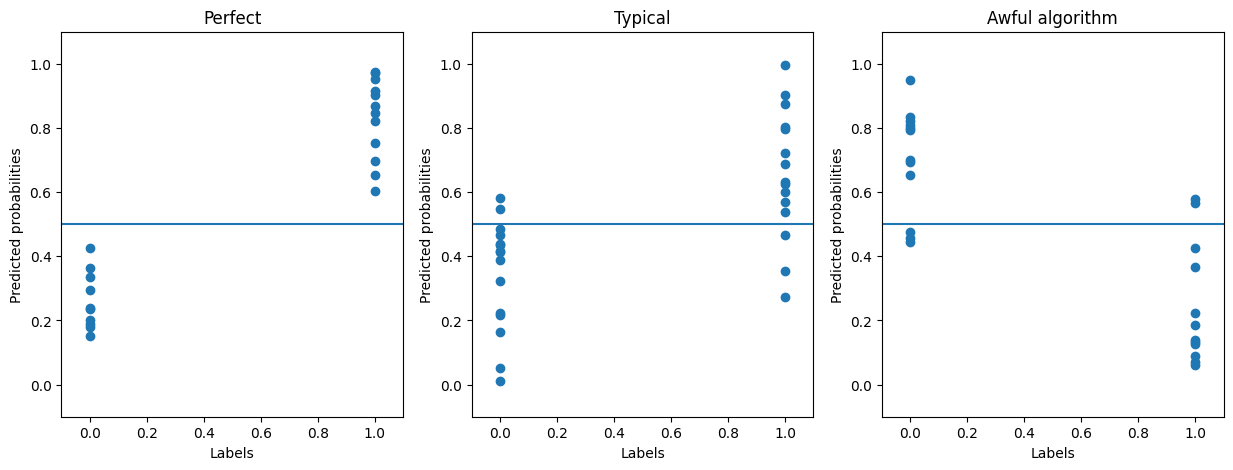

In [97]:
many_scatters([actual_0, actual_1, actual_2],
              [predicted_0, predicted_1, predicted_2],
              [0.5, 0.5, 0.5],
              ["Perfect", "Typical", "Awful algorithm"],
              (1, 3))

**Вопрос**: Можно ли улучшить _типичный_ алгоритм и если можно то как? (а если нельзя, то почему?)

А что на счёт *ужасного* алгоритма, поддаётся ли он улучшению?

Ваш ответ:
1. можно попробовать изменить порог классификации, это должно улучшить модель
2. можно попробовать предсказывать наоборот

Теперь, рассмотрим 2 вида алгоритмов - рискующий и осторожный:

Алгоритм может быть осторожным и стремиться сильно не отклонять вероятности от 0.5, а может рисковать - делать предсказания близакими к нулю или единице.

In [98]:
# рискующий идеальный алгоитм
actual_0r = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_0r = np.array([ 0.23563765,  0.16685597,  0.13718058,  0.35905335,  0.18498365,
            0.20730027,  0.14833803,  0.18841647,  0.01205882,  0.0101424 ,
            0.10170538,  0.94552901,  0.72007506,  0.75186747,  0.85893269,
            0.90517219,  0.97667347,  0.86346504,  0.72267683,  0.9130444 ,
            0.8319242 ,  0.9578879 ,  0.89448939,  0.76379055])

# рискующий хороший алгоритм
actual_1r = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_1r = np.array([ 0.13832748,  0.0814398 ,  0.16136633,  0.11766141,  0.31784942,
            0.14886991,  0.22664977,  0.07735617,  0.07071879,  0.92146468,
            0.87579938,  0.97561838,  0.75638872,  0.89900957,  0.93760969,
            0.92708013,  0.82003675,  0.85833438,  0.67371118,  0.82115125,
            0.87560984,  0.77832734,  0.7593189,  0.81615662,  0.11906964,
            0.18857729])

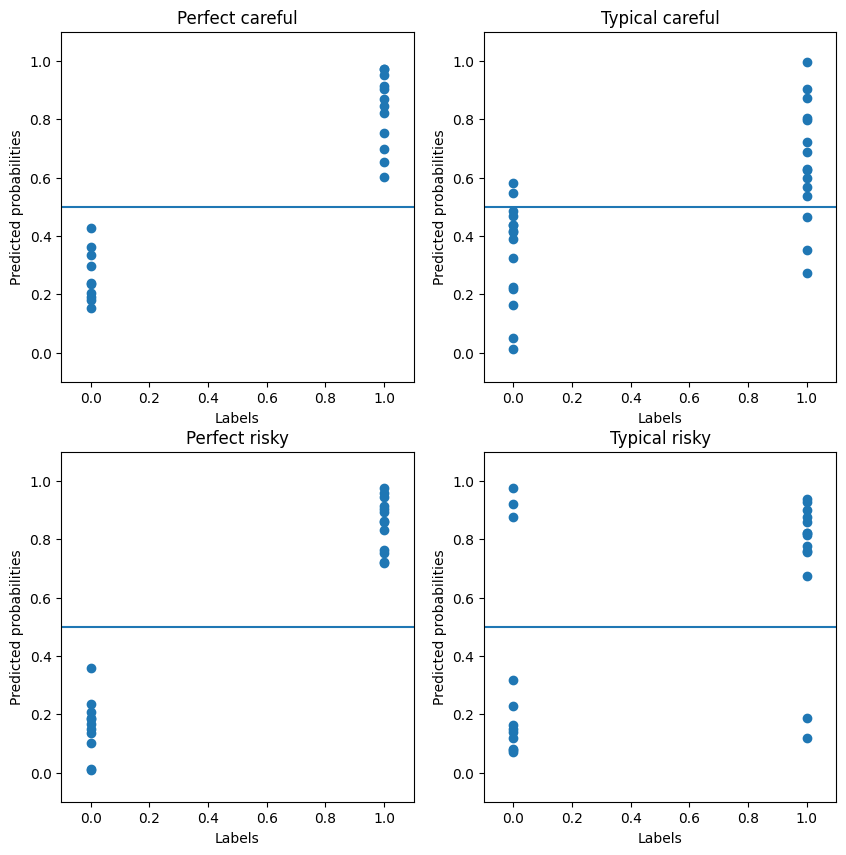

In [99]:
many_scatters([actual_0, actual_1, actual_0r, actual_1r],
              [predicted_0, predicted_1, predicted_0r, predicted_1r],
              [0.5, 0.5, 0.5, 0.5],
              ["Perfect careful", "Typical careful", "Perfect risky", "Typical risky"],
              (2, 2))

Также интервалы могут смещаться. Если алгоритм боится ошибок false positive, то он будет чаще делать предсказания, близкие к нулю. Аналогично, чтобы избежать ошибок false negative, логично чаще предсказывать большие вероятности.

In [100]:
actual_10 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
                1.,  1.,  1.])
predicted_10 = np.array([ 0.29340574, 0.47340035,  0.1580356 ,  0.29996772,  0.24115457,  0.16177793,
                         0.35552878,  0.18867804,  0.38141962,  0.20367392,  0.26418924, 0.16289102,
                         0.27774892,  0.32013135,  0.13453541, 0.39478755,  0.96625033,  0.47683139,
                         0.51221325,  0.48938235, 0.57092593,  0.21856972,  0.62773859,  0.90454639,  0.19406537,
                         0.32063043,  0.4545493 ,  0.57574841,  0.55847795 ])
actual_11 = np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
predicted_11 = np.array([ 0.35929566, 0.61562123,  0.71974688,  0.24893298,  0.19056711,  0.89308488,
            0.71155538,  0.00903258,  0.51950535,  0.72153302,  0.45936068,  0.20197229,  0.67092724,
                         0.81111343,  0.65359427,  0.70044585,  0.61983513,  0.84716577,  0.8512387 ,
                         0.86023125,  0.7659328 ,  0.70362246,  0.70127618,  0.8578749 ,  0.83641841,
                         0.62959491,  0.90445368])

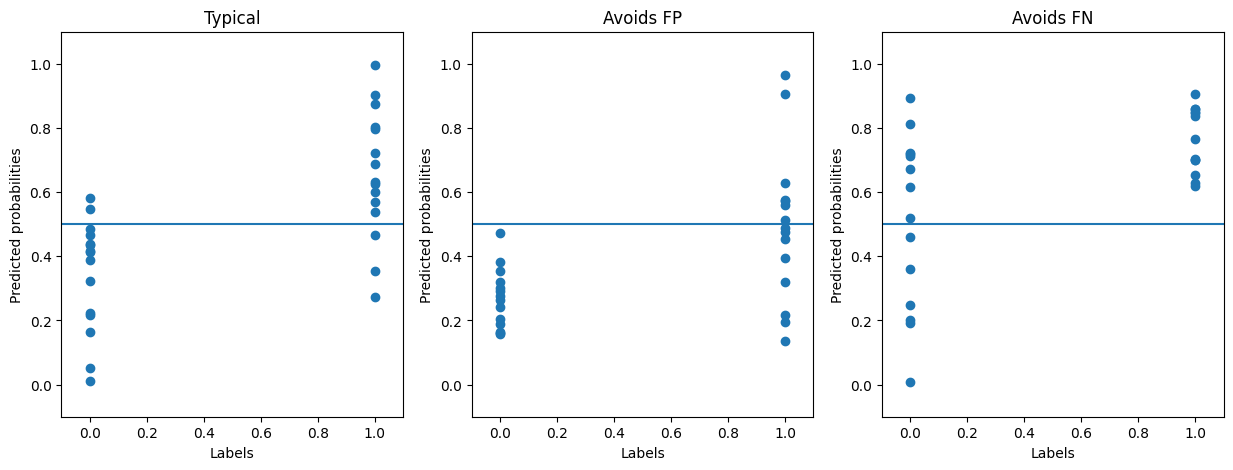

In [101]:
many_scatters([actual_1, actual_10, actual_11],
              [predicted_1, predicted_10, predicted_11],
              [0.5, 0.5, 0.5],
              ["Typical", "Avoids FP", "Avoids FN"],
              (1, 3))

**Вопрос**: что нужно сделать, чтобы *типичный* алгоритм избегал ошибки первого рода? А второго? А как оптимальнее?

Ваш ответ:
1. чтобы избегать ошибки первого рода, можно попробовать повысить порог классифиации
2. чтобы избегать ошибки второго рода, можно попробовать понизить порог классифиации
3. оптимальнее будет выбирать порог исходя из анализа метрики f1

## Precision и recall, accuracy

Для начала разберемся с метриками, оценивающие качество уже после бинаризации по порогу T, то есть сравнивающие два бинарных вектора: actual и predicted.

Две популярные метрики - precision и recall. Первая показывает, как часто алгоритм предсказывает класс 1 и оказывается правым, а вторая - как много объектов класса 1 алгоритм нашел.

Также рассмотрим самую простую и известную метрику - accuracy; она показывает долю правильных ответов.

Выясним преимущества и недостатки этих метрик, попробовав их на разных векторах вероятностей.

#### Напоминание

![](https://i.imgur.com/8xhLDz8.png)

$\LARGE precision = \frac{TP}{TP+FP}$

$\LARGE recall = \frac{TP}{TP+FN}$

In [102]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score

In [103]:
res = []

T = 0.5

for actual, predicted, descr in zip([actual_0, actual_1, actual_2],
                                    [predicted_0 > T, predicted_1 > T, predicted_2 > T],
                                    ["Perfect:", "Typical:", "Awful:"]):
    res.append([descr,
                precision_score(actual, predicted),
                recall_score(actual, predicted),
                accuracy_score(actual, predicted)])

for actual, predicted, descr in zip([actual_1, actual_1r],
                                    [predicted_1 > T, predicted_1r > T],
                                    ["Typical careful:", "Typical risky:"]):
    res.append([descr,
                precision_score(actual, predicted),
                recall_score(actual, predicted),
                accuracy_score(actual, predicted)])

for actual, predicted, descr in zip([actual_10, actual_11],
                                    [predicted_10 > T, predicted_11 > T],
                                    ["Avoids FP:", "Avoids FN:"]):
    res.append([descr,
                precision_score(actual, predicted),
                recall_score(actual, predicted),
                accuracy_score(actual, predicted)])

pd.DataFrame(res, columns=['type', 'precision', 'recall', 'accurasy'])

,type,precision,recall,accurasy
0,Perfect:,1.000000,1.000000,1.000000
1,Typical:,0.857143,0.800000,0.833333
2,Awful:,0.181818,0.166667,0.208333
3,Typical careful:,0.857143,0.800000,0.833333
4,Typical risky:,0.800000,0.857143,0.807692
5,Avoids FP:,1.000000,0.466667,0.724138
6,Avoids FN:,0.619048,1.000000,0.703704


Все три метрики легко различают простые случаи хороших и плохих алгоритмов. Обратим внимание, что метрики имеют область значений `[0, 1]`, и потому их легко интерпретировать.

Метрикам не важны величины вероятностей, им важно только то, сколько объектов неправильно зашли за установленную границу (в данном случае `T = 0.5`).

Метрика `accuracy` дает одинаковый вес ошибкам `false positive` и `false negative`, зато пара метрик `precision` и `recall` однозначно идентифицирует это различие. Собственно, их для того и используют, чтобы контролировать ошибки `FP` и `FN`.

Мы измерили три метрики, фиксировав порог `T = 0.5`, потому что для почти всех картинок он кажется оптимальным. Давайте посмотрим на последней (самой интересной для этих метрик) группе векторов, как меняются `precision` и `recall` при увеличении порога.

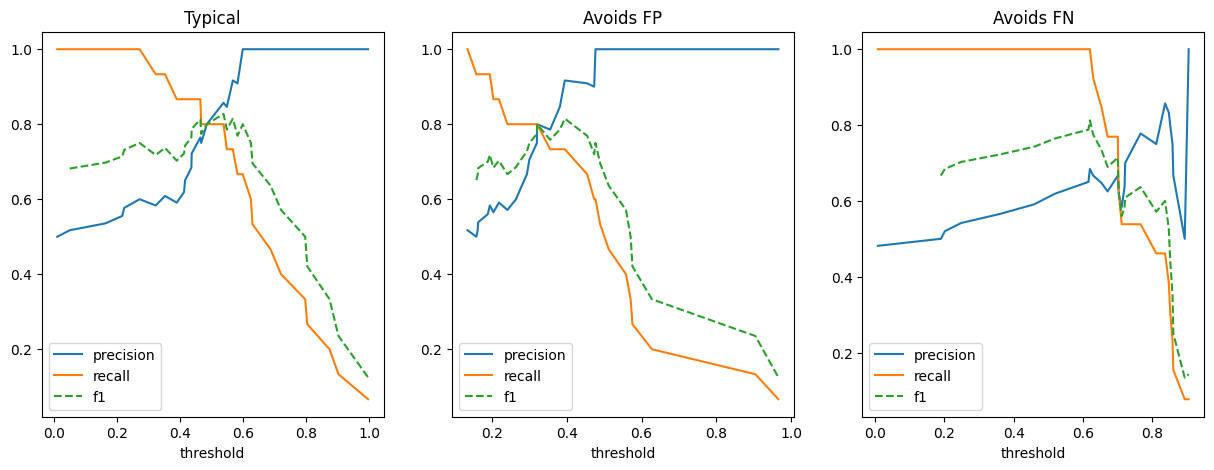

In [104]:
precs = []
recs = []
threshs = []
labels = ["Typical", "Avoids FP", "Avoids FN"]
f1 = []

for actual, predicted in zip([actual_1, actual_10, actual_11], [predicted_1, predicted_10, predicted_11]):
    prec, rec, thresh = precision_recall_curve(actual, predicted)
    precs.append(prec)
    recs.append(rec)
    f1.append(np.array([None] + [f1_score(actual, predicted > t) for t in thresh]))
    threshs.append(thresh)

plt.figure(figsize=(15, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.plot(threshs[i], precs[i][:-1], label="precision")
    plt.plot(threshs[i], recs[i][:-1], label="recall")
    plt.plot(threshs[i], f1[i][:-1], '--', label="f1")
    plt.xlabel("threshold")
    ax.set_title(labels[i])
    plt.legend()

При увеличении порога мы делаем меньше ошибок `FP` и больше ошибок `FN`, поэтому одна из кривых растет, а вторая - падает. По такому графику можно подобрать оптимальное значение порога, при котором `precision` и `recall` будут приемлемы. Если такого порога не нашлось, нужно обучать другой алгоритм.

Оговоримся, что приемлемые значения `precision` и `recall` определяются предметной областью. Например, в задаче определения, болен ли пациент определенной болезнью (0 - здоров, 1 - болен), ошибок `false negative` стараются избегать, требуя `recall` около 0.9. Можно сказать человеку, что он болен, и при дальнейшей диагностике выявить ошибку; гораздо хуже пропустить наличие болезни.

## ROC и AUC

[Хорошее объяснение](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)

При построении ROC-кривой (receiver operating characteristic) происходит варьирование порога бинаризации вектора вероятностей, и вычисляются величины, зависящие от числа ошибок `FP` и `FN`. Эти величины задаются так, чтобы в случае, когда существует порог для идеального разделения классов, ROC-кривая проходила через определенную точку - верхний левый угол квадрата `[0, 1] x [0, 1]`. Кроме того, она всегда проходит через левый нижний и правый верхний углы. Получается наглядная визуализация качества алгоритма. С целью охарактеризовать эту визуализацию численно, ввели понятие AUC - площадь под ROC-кривой.

In [105]:
from sklearn.metrics import roc_curve, roc_auc_score

Perfect:1.000000 Typical:0.884444 Awful:0.041667 Ideal careful:1.000000 Ideal Risky:1.000000 Typical careful:0.884444 Typical risky:0.738095 Typical:0.884444 Avoids FP:0.819048 Avoids FN:0.780220 


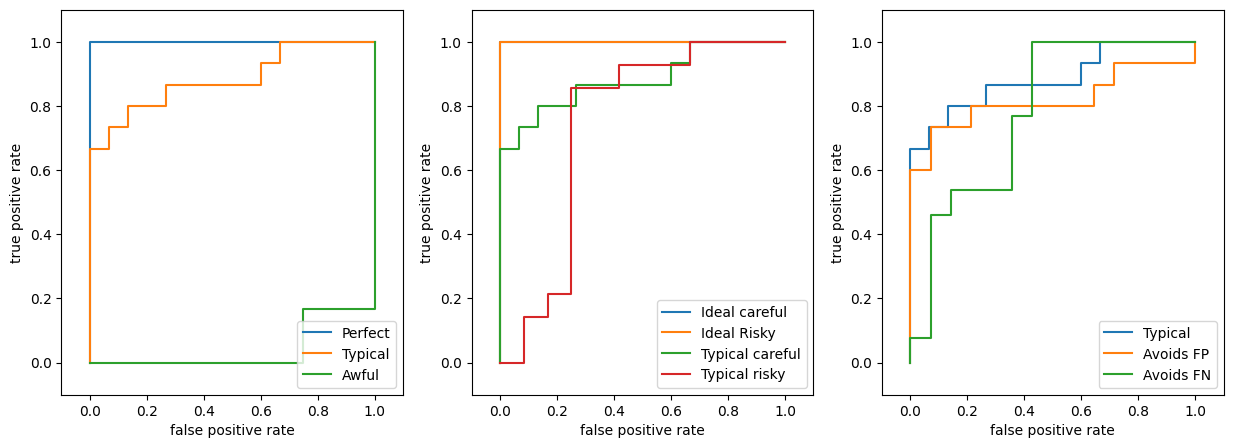

In [106]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
aucs = ""


for actual, predicted, descr in zip([actual_0, actual_1, actual_2],
                                    [predicted_0, predicted_1, predicted_2],
                                    ["Perfect", "Typical", "Awful"]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    plt.plot(fpr, tpr, label=descr)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "


plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.subplot(1, 3, 2)


for actual, predicted, descr in zip([actual_0, actual_0r, actual_1, actual_1r],
                                    [predicted_0, predicted_0r, predicted_1, predicted_1r],
                                    ["Ideal careful", "Ideal Risky", "Typical careful", "Typical risky"]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "
    plt.plot(fpr, tpr, label=descr)


plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.subplot(1, 3, 3)


for actual, predicted, descr in zip([actual_1, actual_10, actual_11],
                                    [predicted_1, predicted_10, predicted_11],
                                    ["Typical", "Avoids FP", "Avoids FN"]):
    fpr, tpr, thr = roc_curve(actual, predicted)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "
    plt.plot(fpr, tpr, label=descr)


plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])
print(aucs)

Чем больше объектов в выборке, тем более гладкой выглядит кривая (хотя на самом деле она все равно ступенчатая).

После того, как кривая построена, удобно выбирать порог бинаризации, в котором будет достигнут компромисс между FP или FN. Порог соответствует точке на кривой. Если мы хотим избежать ошибок FP, нужно выбирать точку на левой стороне квадрата (как можно выше), если FN - точку на верхней стороне квадрата (как можно левее). Все промежуточные точки будут соответствовать разным пропорциям FP и FN.

## Log Loss

Существуют метрики, которые оценивают вероятности в лоб, без использования какого-то порога. Такие метрики полезны, если необходима степень уверенности алгоритма, а не сам класс.

$\Large log\_loss(y, y') = - \frac 1 n \sum_{i=1}^n (y_i \cdot \log (y'_i) + (1-y_i) \cdot \log (1-y'_i))$,

где $n$ - длина векторов.

`Log Loss` можно обобщить на мультилейбл классификацию.

In [107]:
from sklearn.metrics import log_loss

res = []

for actual, predicted, descr in zip([actual_0, actual_1, actual_2],
                                    [predicted_0, predicted_1, predicted_2],
                                    ["Perfect:", "Typical:", "Awful:"]):
    res.append([descr,
                log_loss(actual, predicted)])

for actual, predicted, descr in zip([actual_1, actual_1r],
                                    [predicted_1, predicted_1r],
                                    ["Typical careful:", "Typical risky:"]):
    res.append([descr,
                log_loss(actual, predicted)])

for actual, predicted, descr in zip([actual_10, actual_11],
                                    [predicted_10, predicted_11],
                                    ["Avoids FP:", "Avoids FN:"]):
    res.append([descr,
                log_loss(actual, predicted)])

pd.DataFrame(res, columns=['type', 'log_loss'])

,type,log_loss
0,Perfect:,0.249213
1,Typical:,0.464507
2,Awful:,1.527025
3,Typical careful:,0.464507
4,Typical risky:,0.613875
5,Avoids FP:,0.584934
6,Avoids FN:,0.588679


 **Опишите, как бы вы предложили обобщить log-loss для мультиклассового случая**

Ваш ответ: можно посчитать потери для каждого класса и просуммировать потери по всем классам

$$-\frac{1}{N}\sum^{N-1}_{i=0}\sum^{K-1}_{k=0}y_{i,k}\log{p_{i,k}}$$
